In [1]:
# Initialize workspace
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as pyp
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import svgutils.compose as sc
import svgutils.transform as sg

In [2]:
# Colors
col = {
    'dkGrey':   '#202020',  # dark grey 
    'dkRed':    '#362121',  # dark redish  
    'dkBlue':   '#001526',  # dark blueish  

    # text and decorations 

    'purple':   '#9469AD',  # purple  
    'blue':     '#88C9C1',  # blue  
    'offwhite': '#FFF8D0',  # offwhite  
    'orange':   '#F79A52',  # orange  
    'red':      '#E04B4B',  # red  
    'green':    '#73B55B',  # green
    'grey':     '#d2d2d2',  # grey
};

In [3]:
# configure plot behavior
params = {
    'axes.edgecolor': col['grey'],
    'axes.labelcolor': col['grey'],
    'xtick.color': col['grey'],
    'ytick.color': col['grey'],
    'grid.color': col['grey']
}

In [4]:
for p in params:
    mpl.rcParams[p] = params[p]

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Custom functions

In [5]:
class customError(Exception):
  pass
def domain(array, trunc=True):
    if trunc:
        return [np.min(array), np.max(array)]
    return {'low': np.min(array), 'high': np.max(array)}
def nan_helper(dat):
    if not isinstance(dat,np.ndarray):
        dat = np.array(dat)
    return np.isnan(dat), lambda z: z.nonzero()[0]

# Make a list of twinX axes
def multiX(ax,n=2,concatOriginal=False):
    twins = []
    if concatOriginal:
        twins.append(ax)
    for _ in range(n):
        twins.append(ax.twinx())
    return twins
# Histogram Data and make a dot-plot
def makeDots(data, type='discrete', kdeArgs= {'poolSize':10000}, **histArgs):
    '''
    Calculate a histogram from provided data and
    convert to x,y points for scatter plot.
    Inputs: 
        data= 1D array for histogram
        type= string: 'discrete' [default] or 'continuous'
        density= bool: convert counts to densities
        **histArgs= keyword args for np.histogram() fun
    Output: A dict with keys
        x: x vector
        y: y vector
    '''
    output = {}
    type = validateString(type, ['discrete', 'continuous']);
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    # parse keyword args
    density= histArgs.pop('density',False)
    if type == 'discrete':
        # Compute bin edges and counts
        h= np.histogram(data,**histArgs)
        # Calculate bin centers
        binCenters = np.diff(h[1])/2 + h[1][:-1]
        # create x position vector from bin centers and counts
        xs= np.repeat(binCenters, h[0])
        #init zeros array for y positions
        ys= np.zeros(h[0].sum())
        start= 0
        stop= 0
        for val in h[0]:
            if val:
                stop += val
                ys[start:stop] = np.arange(val)+0.5
                start= stop
        if density:
            db = np.repeat(np.diff(h[1]), h[0])
            ys= ys/db/h[0].sum()
        output.update({'x':xs, 'y':ys})
    elif type == 'continuous':
        np.random.seed(4443451)
        datLen = data.shape[-1]
        h= np.histogram(data,density=True,**histArgs);
        uSize = kdeArgs.pop('poolSize',10*datLen) / 2
        kdeFun= stats.kde.gaussian_kde(data,**kdeArgs)
        h = np.array(h)
        h[0] = np.append(h[0],0)
        yDomain = domain(h[0], trunc=False)
        xDomain = domain(h[1], trunc=False)
        inds = np.array([])
        uFactor = 2
        outlen = 0
        while outlen < datLen:
            uSize *= uFactor
            xUnif = np.random.uniform(**xDomain, size = int(uSize))
            yUnif = np.random.uniform(**yDomain, size = int(uSize))
            for x in range(int(uSize)):
                yUnif[x] = yUnif[x] if yUnif[x] < kdeFun(xUnif[x]) else np.nan
            nans, fn = nan_helper(yUnif)
            inds = fn(~nans);
            outlen = inds.shape[-1]
            
        inds = np.random.choice(inds, replace=False, size=datLen);
        output.update({'x':xUnif[inds], 'y': yUnif[inds], 'kernel': kdeFun})

    return output

# convert strings to multi-factor or vectors to 
def expandGrid(*vals, doPaste = True, sep = ' ', expansion=None):
    '''
    Takes unnamed inputs and creates a matrix of all possible combinations. Rows of the
    resulting matrix can be pasted together as strings using the provided separator ,sep.
    '''
    if len(vals) == 1:
        return np.array([*vals])
    output = np.array(
        np.meshgrid(*vals)
      ).reshape(len(vals),-1).T
    output = output[output[:,0].argsort(),:]
    if doPaste:
        stringOut = [];
        for row in range(output.shape[0]):
            stringOut.append(sep.join(output[row,:]))
        output = np.array(stringOut)
    
    if expansion is not None:
        print(output.shape[0])
        if (len(expansion) != output.shape[0]):
            import warnings
            warnings.warn('Length of "expansion" must be the same as output.')
            return output
        output = np.repeat(output, expansion, axis=0);
    return output

'''
Validate String

takes an input string and outputs the matching string from an string listats.
'''
def validateString(inputString, argList, method=None):
    if method is not None:
        # use recursion, sorta, to validate method.
        method = validateString(method, ['exact', 'approx'],method= None)

    if method == 'exact':
        ind = [a for a,s in enumerate(argList) if inputString.lower() == s.lower()]
    elif method == 'approx':
        ind = [a for a,s in enumerate(argList) if inputString.lower() in s.lower()]
    else:
        #default to approx
        ind = [a for a,s in enumerate(argList) if inputString.lower() in s.lower()]
    try:
        ind = ind[0]
    except IndexError:
        raise customError('Invalid String!')
    return argList[ind]

# Uncertainty

In [6]:
# 2 datasets, make a dot plot on a number line
#dataTight= np.random.normal(2,1,12)
#dataLoose= np.random.normal(15,3,12)
dataTight= np.array([ 4.12409242,  1.27090469,  1.94865372,  3.89272027,  1.95164675,  
                    0.82544233,  1.98784184,  2.75400644,  2.83867143,  0.2255899,
                    0.8649331,   2.07200741])+5;
dataLoose= np.array([ 12.95016274,  14.03794331,  20.26063078,   8.10156477,  15.58212113,
                     16.27736142,  10.60021264,  14.08910245,  17.95757537,  15.08191923,
                     15.8619412,   18.06695377])-5;

hTight= makeDots(dataTight,density=False,bins='fd')
hLoose= makeDots(dataLoose,density=False,bins='fd')
yMin= np.append(hTight['y'].min(),hLoose['y'].min()).min()

yMax= np.append(hTight['y'].max(),hLoose['y'].max()).max()

fig = pyp.figure(figsize=(12,2))
axs = fig.subplots(1,2)

axs[0].scatter(**hTight, color='xkcd:greenish', edgecolors='black',zorder=5,s=200);
axs[1].scatter(**hLoose, color='xkcd:cloudy blue', edgecolors='black', s=200);

pyp.tight_layout()
for ax in axs:
    ax.set_ylim((0,yMax*1.5))
    ax.set_xlim((0,20))
    ax.set_yticks([])
    ax.set_xlabel("Observed Value", size=20, labelpad=10)
    ax.tick_params(width=1, labelsize=15)
    ax.set_xticks(np.linspace(0,20,6))
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    
#fig.savefig("../img/precisionDots.svg")

## Outlier affects mean

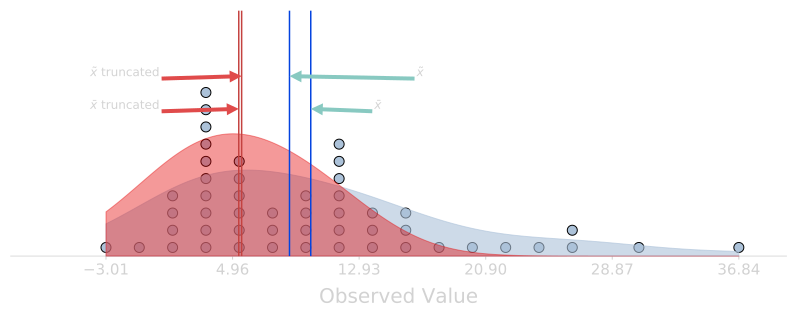

In [126]:
## random data
outlier = stats.gumbel_r(5, 6).rvs(50);
non = outlier.copy()
non.sort()
non = non[:35]

theDots = makeDots(outlier,density=True,bins=20)

fig = pyp.figure(figsize=(12,4))
ax = fig.subplots(1,1)
axs = multiX(ax, n= 4, concatOriginal=True)


yMin= theDots['y'].min()

yMax= theDots['y'].max()

xMin= theDots['x'].min()

xMax= theDots['x'].max()

xlin = np.linspace(xMin,xMax,500)

kdeAll = stats.gaussian_kde(outlier,bw_method=0.5)
kdeTrunc = stats.gaussian_kde(non,bw_method=1)

axs[3].axvline(np.mean(outlier), color='xkcd:blue')
axs[4].axvline(np.mean(non), color='xkcd:reddish')
axs[3].axvline(np.median(outlier), color='xkcd:blue')
axs[4].axvline(np.median(non), color='xkcd:reddish')
axs[4].annotate(
    r"$\bar{x}$ truncated",
    xy=(np.mean(non),yMax*0.9), 
    xytext=(xMin-1,0.9*yMax),
    size=5,
    fontsize=12,
    color = '#d3d3d3',
    arrowprops=dict(
        fc=col['red'], 
        ec="none"
    )
);
axs[4].annotate(
    r"$\tilde{x}$ truncated",
    xy=(np.median(non),yMax*1.1), 
    xytext=(xMin-1,1.1*yMax),
    size=5,
    fontsize=12,
    color = '#d3d3d3',
    arrowprops=dict(
        fc=col['red'], 
        ec="none"
    )
);
axs[3].annotate(
    r"$\bar{x}$",
    xy=(np.mean(outlier),yMax*0.9), 
    xytext=(np.mean(outlier)+4,0.9*yMax),
    size=5,
    fontsize=12,
    color = '#d3d3d3',
    arrowprops=dict(
        fc=col['blue'], 
        ec="none"
    )
);
axs[3].annotate(
    r"$\tilde{x}$",
    xy=(np.median(outlier),yMax*1.1), 
    xytext=(np.median(outlier)+8,1.1*yMax),
    size=5,
    fontsize=12,
    color = '#d3d3d3',
    arrowprops=dict(
        fc=col['blue'], 
        ec="none"
    )
);
axs[0].scatter(**theDots, color='xkcd:cloudy blue', edgecolors='black',zorder=5,s=100);
axs[1].fill_between(xlin, kdeAll(xlin), color = 'xkcd:cloudy blue', zorder=1, alpha = 0.6)
axs[2].fill_between(xlin, kdeTrunc(xlin), color = 'xkcd:red', zorder=1, alpha = 0.4)

pyp.tight_layout()
for ax in axs:
    ax.axis('off');
    ax.set_ylim((0,yMax*1.5))
    ax.set_xlim((xMin-6,xMax+3))
    ax.set_yticks([])
    ax.set_xlabel("Observed Value", size=20, labelpad=10)
    ax.tick_params(width=1, labelsize=15)
    ax.set_xticks(np.linspace(xMin,xMax,6))
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
axs[0].axis('on')
fig.savefig("../img/outlierKG.svg", transparent=True)

In [34]:
kdeAll()

# Distribution skewness and symmetry

In [28]:
# xspace
mu= 90
s= 7
x= np.arange(0,180,0.01)
# data
LEFT = stats.gumbel_l(55, 8);
CENTER = stats.norm;
RIGHT = stats.gumbel_r(125, 8);
# stats
Lstats = {
    "mean":   LEFT.mean(),
    "median": LEFT.median(),
    "mode":   x[np.nonzero(LEFT.pdf(x) == np.max(LEFT.pdf(x)))]
}
Rstats = {
    "mean":   RIGHT.mean(),
    "median": RIGHT.median(),
    "mode":   x[np.nonzero(RIGHT.pdf(x) == np.max(LEFT.pdf(x)))]
}
Cstats = {
    "mean":   CENTER.mean(mu,s),
    "median": CENTER.median(mu,s),
    "mode":   x[np.nonzero(CENTER.pdf(x,mu,s) == np.max(CENTER.pdf(x,mu,s)))]
}

# linCol
lCol = {
    'mean': col['red'],
    'median': col['orange'],
    'mode': col['dkBlue']
}
# plot
fig, ax = pyp.subplots()
fig.set_size_inches((12,3))
ax = multiX(ax=ax, n=9, concatOriginal=True)
# base densities
ax[0].fill_between(x, RIGHT.pdf(x), color = col['grey'], zorder = 1);
ax[1].fill_between(x, LEFT.pdf(x), color = col['grey'], zorder = 2);
ax[2].fill_between(x, CENTER.pdf(x, mu, s), color = col['blue'], zorder = 3);

for a in ax:
    a.set_ylim([0,ax[2].get_ylim()[1]])
    a.axis('off');
    
# lines
for s in ['mean','median','mode']:
    RyL = RIGHT.pdf(Rstats[s])/ax[0].get_ylim()[1]
    LyL = LEFT.pdf(Lstats[s])/ax[1].get_ylim()[1]
    CyL = CENTER.pdf(90,90,7) / ax[2].get_ylim()[1]
    ax[3].axvline(x= Rstats[s], ymax= RyL, color= lCol[s], lw=2)
    ax[4].axvline(x= Lstats[s], ymax= LyL, color= lCol[s], lw=2)
    ax[5].axvline(x= Cstats[s], ymax= CyL, color= lCol[s], lw=2)




In [24]:
Cstats

{'mean': 90.0, 'median': 90.0, 'mode': array([ 90.])}

# Population and Sample

In [9]:
n = 600
lSkewFn = stats.gumbel_l(85, 6)
lSkewData = lSkewFn.rvs(n)

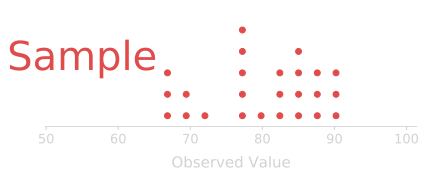

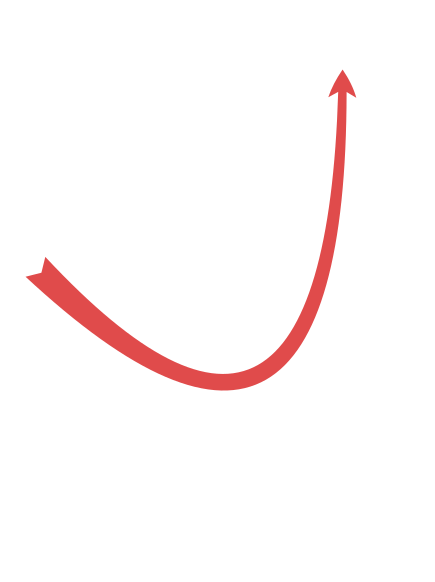

In [13]:
sampleInds = np.random.randint(0, lSkewData.size, size=25)
data = makeDots(lSkewData, type='cont')

xLine = np.linspace(data['x'].min(),data['x'].max(),n)

fig = pyp.figure(figsize=(6*1.3,4*1.3))
ax = fig.subplots(1,1)
#plot
ax.scatter(
    data['x'][[i for i in range(data['x'].size) if i not in sampleInds]],
    data['y'][[i for i in range(data['y'].size) if i not in sampleInds]], 
    s=16, 
    color=col['blue']
)
ax.scatter(
    data['x'][sampleInds], 
    data['y'][sampleInds], 
    s=30, 
    color=col['red']
)
ax.plot(
    xLine,
    data['kernel'](xLine),
    color= col['green'],
    lw=4,
    zorder=1
)
#style
pyp.tight_layout()
ax.set_ylim((0,data['y'].max()*1.25))
ax.set_yticks([])
ax.set_xlabel("Observed Value", size=20, labelpad=10)
ax.tick_params(width=1, labelsize=15)
ax.set_xlim((data['x'].min()*0.9,data['x'].max()*1.05))
#ax.set_xticks(np.linspace(0,20,6))
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

ax.text(
    s='Population', 
    x= 55, 
    y=data['y'].max()*0.25, 
    color = col['blue'], 
    fontsize=40,
    horizontalalignment='center'
)

fig.savefig('./data/PopSampKDE.svg',transparent=True)

## sample data dots
sampleData = makeDots(data['x'][sampleInds],density=True)
fig = pyp.figure(figsize=(6,2.2))
ax = fig.subplots(1,1)
ax.scatter(sampleData['x'],sampleData['y'], color=col['red'])
pyp.tight_layout()
ax.set_ylim((0,sampleData['y'].max()*1.2))
ax.set_yticks([])
ax.set_xlabel("Observed Value", size=15, labelpad=10)
ax.tick_params(width=1, labelsize=13)
ax.set_xlim((data['x'].min()*0.9,data['x'].max()*1.05))
#ax.set_xticks(np.linspace(0,20,6))
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)

ax.text(
    s='Sample', 
    x= 55, 
    y=sampleData['y'].max()*0.9, 
    color = col['red'], 
    fontsize=40,
    horizontalalignment= 'center',
    verticalalignment= 'top'
)
 
fig.savefig('./data/PopSampSub.svg',transparent=True)

fig = pyp.figure(figsize=(7,5.2))
ax = fig.subplots(1,1)
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.axis('off')
ax.annotate(
    "",
    xy=(0.8,0.8), 
    xytext=(0.01,0.1),
    size=70,
    arrowprops=dict(
        arrowstyle='fancy',
        fc=col['red'], 
        ec="none",
        connectionstyle="angle3,angleA=-45,angleB=-90"
    )
);
fig.savefig('./data/PopSampArrow.svg',transparent=True)

In [17]:
#load and reorganize
big = sc.SVG('./data/PopSampKDE.svg')
little = sc.SVG('./data/PopSampSub.svg')
arrow = sc.SVG('./data/PopSampArrow.svg')
sfig= sc.Figure(
    "8.35in",
    "4.5in",
    big.move(10,0),
    little.move(460,40).scale(0.9), 
    arrow.scale(0.6).move(410,150)
).save("../img/PopSamp.svg")
from IPython.display import SVG
SVG("../img/PopSamp.svg")

# Monte Carlo

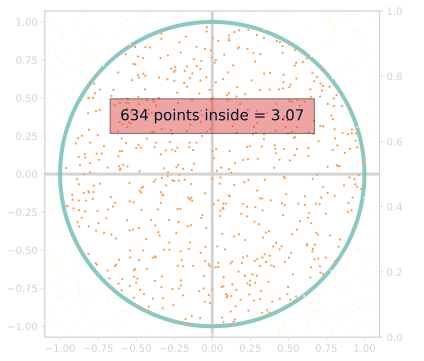

In [83]:
domain = np.linspace(-np.pi,np.pi,500)
nunif = 1000

x = np.cos(domain)
y = np.sin(domain)
unif = {
    'x': np.random.uniform(low=-1.1, high=1.1, size=nunif),
    'y': np.random.uniform(low=-1.1, high=1.1, size=nunif)
}
def circheck(x,y):
    return (x-0)**2+(y-0)**2 <= 1

cUn = {'x':[],'y':[]}
for i in range(nunif):
    
    if circheck(unif['x'][i],unif['y'][i]):
        cUn['x'].append(unif['x'][i])
        cUn['y'].append(unif['y'][i])

fig = pyp.figure(figsize=(6,6))
ax = fig.subplots()
ax2 = pyp.twinx(ax);
ax3 = pyp.twinx(ax);
ax4 = pyp.twinx(ax);

# circle
ax.plot(x,y, color = col['blue'], lw= 4, zorder = 5);
ax.axvline(0, color='#d3d3d3', lw=3, zorder=1);
ax.axhline(0, color='#d3d3d3', lw=3, zorder=1);

#unif
ax2.scatter(**unif, color=col['offwhite'], s=1 )

#col
ax3.scatter(**cUn, color = col['orange'], s=1.5)

for a in [ax,ax2,ax3]:
    a.axis('equal');
    a.set_xlim([-1.1,1.1]);
    a.set_ylim([-1.1,1.1]);
ax2.axis('off');
ax3.axis('off');

# text
npts = len(cUn['x'])
ax4.text(
    0.5,
    0.7,
    '{0:d} points inside = {1:0.2f}'.format(npts,npts/nunif*(1.1+1.1)**2),
    verticalalignment='top', horizontalalignment='center',
    color=col['dkBlue'], 
    fontsize=15,
    transform=ax4.transAxes,
    bbox={'facecolor':col['red'], 'alpha':0.5,'pad':10}
)

# save
fig.savefig('../img/montecarloCirclefew.svg', transparent=True)

In [68]:
npts/nunif * (1.1-(-1.1))**2



3.0976000000000004

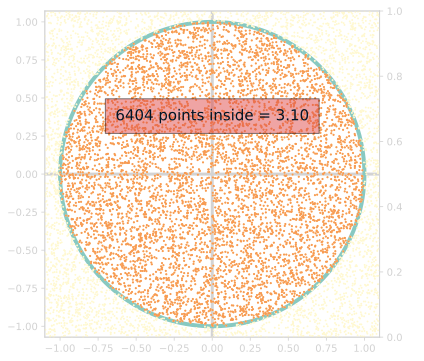

In [82]:
domain = np.linspace(-np.pi,np.pi,500)
nunif = 10000

x = np.cos(domain)
y = np.sin(domain)
unif = {
    'x': np.random.uniform(low=-1.1, high=1.1, size=nunif),
    'y': np.random.uniform(low=-1.1, high=1.1, size=nunif)
}
def circheck(x,y):
    return (x-0)**2+(y-0)**2 <= 1

cUn = {'x':[],'y':[]}
for i in range(nunif):
    
    if circheck(unif['x'][i],unif['y'][i]):
        cUn['x'].append(unif['x'][i])
        cUn['y'].append(unif['y'][i])

fig = pyp.figure(figsize=(6,6))
ax = fig.subplots()
ax2 = pyp.twinx(ax);
ax3 = pyp.twinx(ax);
ax4 = pyp.twinx(ax);

# circle
ax.plot(x,y, color = col['blue'], lw= 4, zorder = 5);
ax.axvline(0, color='#d3d3d3', lw=3, zorder=1);
ax.axhline(0, color='#d3d3d3', lw=3, zorder=1);

#unif
ax2.scatter(**unif, color=col['offwhite'], s=1 )

#col
ax3.scatter(**cUn, color = col['orange'], s=1.5)

for a in [ax,ax2,ax3]:
    a.axis('equal');
    a.set_xlim([-1.1,1.1]);
    a.set_ylim([-1.1,1.1]);
ax2.axis('off');
ax3.axis('off');

# text
npts = len(cUn['x'])
ax4.text(
    0.5,
    0.7,
    '{0:d} points inside = {1:0.2f}'.format(npts,npts/nunif*(1.1+1.1)**2),
    verticalalignment='top', horizontalalignment='center',
    color=col['dkBlue'], 
    fontsize=15,
    transform=ax4.transAxes,
    bbox={'facecolor':col['red'], 'alpha':0.5,'pad':10}
)

# save
fig.savefig('../img/montecarloCirclemany.svg', transparent=True)

## UCLA v USC

0.0286


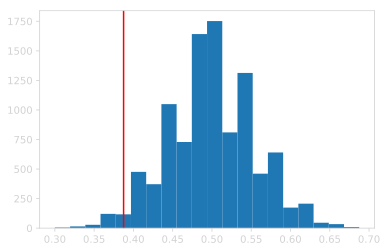

In [47]:
# props and helpers
B = 10000
def getPro(x):
    return(np.sum(x)/x.shape[-1])
alpha = 0.05
# proportions
UCLA = 31
USC = 49
TOTAL = USC+UCLA

pLA = UCLA/(TOTAL+0.0)
pSC = USC/(TOTAL+0.0)

# Construct Null
P = 0.5
bootsNull = np.random.choice([0,1],replace=True, size=(B,TOTAL), p=(1-P,P))
bootsNull_proportions = np.apply_along_axis(getPro,axis=1,arr=bootsNull)
alphaLevel= [np.percentile(bootsNull_proportions, 100*alpha/2),np.percentile(bootsNull_proportions, 100*(1-alpha/2))];
pcount = np.sum(bootsNull_proportions <= pLA)
pval = pcount / B

# Construct CI
bootsCI = np.random.choice([0,1],replace=True, size=(B,TOTAL), p=(1-pLA,pLA))
bootsCI_proportions = np.apply_along_axis(getPro,axis=1,arr=bootsCI)
cilevel = [np.percentile(bootsCI_proportions, 100*alpha/2),np.percentile(bootsCI_proportions, 100*(1-alpha/2))]

#tmp plot
pyp.hist(bootsNull_proportions, bins = 20)
pyp.axvline(pLA, color='red')
print(pval)

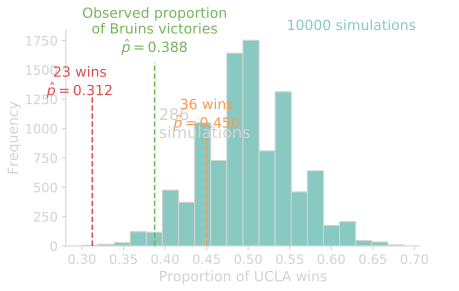

In [61]:
fig = pyp.figure(figsize=(6,4))
ax1 = fig.add_axes([0.14, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()

ax1.hist(bootsNull_proportions, bins=20, edgecolor=col["grey"], color=col["blue"])

for spine in ["bottom", "left"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(col["grey"])
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_ylim(0)
    ax.tick_params(axis="both", width=1, size=4, color=col["grey"], labelcolor=col["grey"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Proportion of UCLA wins", size=14, color=col["grey"])
    ax.set_ylabel("Frequency", size=14, color=col["grey"])
    ax.text(ax.get_xlim()[1]-0.005, ax.get_ylim()[1], "{:d} simulations".format(B), size=14, color=col["blue"], ha="right")

for ax in [ax2, ax3, ax4, ax5]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")

for ax in [ax2]:
    ax.axvline(pLA, ymax=0.85, color=col["green"], ls="--")
    ax.text(pLA, ax2.get_ylim()[1]*0.9, "Observed proportion\nof Bruins victories\n$\hat{p}=$"+"{:0.3f}".format(pLA), size=14, color=col["green"], ha="center")
    
for ax in [ax3]:
    ax.text(pLA+0.005, ax2.get_ylim()[1]*0.5, "{}\nsimulations".format(pcount), size=16, color=col["grey"], ha="left")

for ax in [ax4]:
    up = (UCLA+5.0)/TOTAL
    ax.axvline(up, ymax=0.5, color=col["orange"], ls="--")
    ax.text(up, ax2.get_ylim()[1]*0.55, "{0:d} wins\n$\hat{{p}}=${1:.3f}".format(UCLA+5,up), size=14, color=col["orange"], ha="center")


for ax in [ax5]:
    down = (UCLA-6.0)/TOTAL
    ax.axvline(down, ymax=0.7, color=col["red"], ls="--")
    ax.text(down-0.015, ax2.get_ylim()[1]*0.7, "{0:d} wins\n$\hat{{p}}=${1:.3f}".format(UCLA-8,down), size=14, color=col["red"], ha="center")

fig.savefig("../img/ucla-usc-NULL-kg.svg", transparent=True)

## simulate N games but proportions same

In [60]:
# Simulate different number of games
nGames = [TOTAL-30, TOTAL + 30]
bNu = [];
bCI = [];
CIs = [];
arn = [];
pvls = [];

for ng in nGames:
    bn = np.random.choice([0,1],replace=True, size=(B,ng),p=(1-P,P))
    bnP = np.apply_along_axis(getPro,axis=1,arr=bn)
    alvl= [np.percentile(bnP, 100*alpha/2),np.percentile(bnP, 100*(1-alpha/2))];
    pc = np.sum(bnP <= pLA)
    pv = pc / B

    # Construct CI
    bCIs = np.random.choice([0,1],replace=True, size=(B,TOTAL), p=(1-pLA,pLA))
    bCIp = np.apply_along_axis(getPro,axis=1,arr=bCIs)
    clvl = [np.percentile(bCIp, 100*alpha/2),np.percentile(bCIp, 100*(1-alpha/2))]
    # push to vects
    bNu.append(bnP)
    bCI.append(bCIp)
    arn.append(alvl)
    pvls.append((pc,pv))
    CIs.append(clvl)
                                 

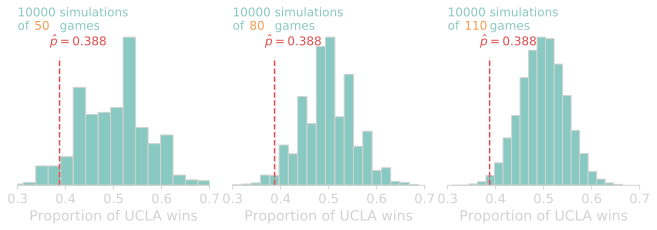

In [63]:
fig, (ax1, ax2, ax3) = pyp.subplots(ncols=3, figsize=(9, 3))

ax1.hist(bNu[0], bins=20, edgecolor=col["grey"], color=col["blue"])
ax2.hist(bootsNull_proportions, bins=20, edgecolor=col["grey"], color=col["blue"])
ax3.hist(bNu[1], bins=20, edgecolor=col["grey"], color=col["blue"])

for ax,games in zip([ax1, ax2, ax3], [nGames[0], TOTAL, nGames[1]]):
    ax.axvline(pLA, ymax=0.82, color=col["red"], ls="--")
    ax.text(pLA-0.02, ax.get_ylim()[1]*0.9, "$\hat{p}=$"+"{:0.3f}".format(pLA), size=12, color=col["red"], ha="left")
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(col["grey"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="x", width=1, size=4, color=col["grey"], labelcolor=col["grey"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Proportion of UCLA wins", size=14, color=col["grey"])
    ax.set_xlim(0.3, 0.7)
    ax.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7])
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1], "10000 simulations\nof        games", size=12, color=col["blue"], ha="left")
    ax.text(ax.get_xlim()[0]+0.035, ax.get_ylim()[1], "{}".format(games), size=12, color=col["orange"], ha="left")


#pyp.tight_layout()
pyp.subplots_adjust(left=0.02, bottom=0.17, right=0.98, top=0.89,
                wspace=0.12, hspace=None)

fig.savefig("../img/ucla-usc-NULL2-kg.svg", transparent=True)

## Tailedness

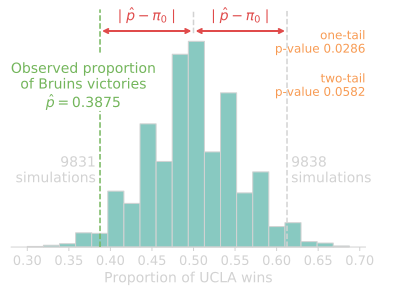

In [76]:
delta = np.abs(pLA-P) #sign?

fig = pyp.figure(figsize=(6,4))
ax1 = fig.add_axes([0.14, 0.15, 0.82, 0.75])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()

ax1.hist(bootsNull_proportions, bins=20, edgecolor=col["grey"], color=col["blue"])

for spine in ["bottom"]:
    ax1.spines[spine].set_linewidth(1)
    ax1.spines[spine].set_color(col["grey"])
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)

for ax in [ax1]:
    ax.set_yticks([])
    ax.tick_params(axis="both", width=1, size=4, color=col["grey"], labelcolor=col["grey"], 
                   labelsize=13, pad=4)
    ax.set_xlabel("Proportion of UCLA wins", size=14, color=col["grey"])

for ax in [ax2, ax3, ax4, ax5]:
    ax.set_ylim(ax1.get_ylim())
    ax.axis("off")

for ax in [ax2]:
    ax.axvline(pLA, ymax=0.63, color=col["green"], ls="--")
    ax.text(pLA-0.02, ax.get_ylim()[1]*0.65, 
            "Observed proportion\nof Bruins victories\n$\hat{p}=$"+"{}".format(pLA), 
            size=14, 
            color=col["green"], ha="center")
    ax.text(pLA-0.005, ax.get_ylim()[1]*0.3, 
            "{}\nsimulations".format(np.sum(bootsNull_proportions>=pLA)), 
            size=14, color=col["grey"], 
            ha="right")
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1]*0.9, 
            "one-tail\np-value {}".format(np.sum(bootsNull_proportions<=pLA)/B), 
            size=12, 
            color=col["orange"], ha="right")

for ax in [ax3]:
    ax.axvline(pLA, ymin=0.90, ymax=1.1, color=col["green"], ls="--", clip_on=False)
    #center of distribution
    ax.axvline(0.5, ymin=0.99, ymax=1.1, color=col["grey"], ls="--", clip_on=False)
    #annotations
    ax.text((0.5+pLA)/2, 1.05*ax.get_ylim()[1], "$\mid\hat{p}-\pi_0\mid$", size=14, color=col["red"], ha="center")
    ax.annotate(s='', xy=(0.5,1*ax.get_ylim()[1]), xytext=(pLA,1*ax.get_ylim()[1]), 
             arrowprops=dict(arrowstyle='<->', color=col["red"],
                            linewidth=2))
for ax in [ax4]:
    #lower tail
    ax.axvline(1-(pLA), ymin=0, ymax=1.1, color=col["grey"], ls="--", clip_on=False)
    ax.text((0.5+(1-(pLA)))/2, 1.05*ax.get_ylim()[1], "$\mid\hat{p}-\pi_0\mid$", size=14, color=col["red"], ha="center")
    ax.annotate(s='', xy=(1-pLA,1*ax.get_ylim()[1]), xytext=(0.5,1*ax.get_ylim()[1]), 
             arrowprops=dict(arrowstyle='<->', color=col["red"],
                            linewidth=2))

for ax in [ax5]:
    ax.text(1-pLA+0.005, ax.get_ylim()[1]*0.3, 
            "{}\nsimulations".format(np.sum(bootsNull_proportions<=(1-pLA))), size=14, color=col["grey"], ha="left")
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1]*0.7, 
            "two-tail\np-value {}".format((np.sum(bootsNull_proportions>=(1-pLA))+np.sum(bootsNull_proportions<=pLA))/B), 
            size=12, color=col["orange"], ha="right")

fig.savefig("../img/ucla-usc-PVALS-kg.svg", transparent=True)

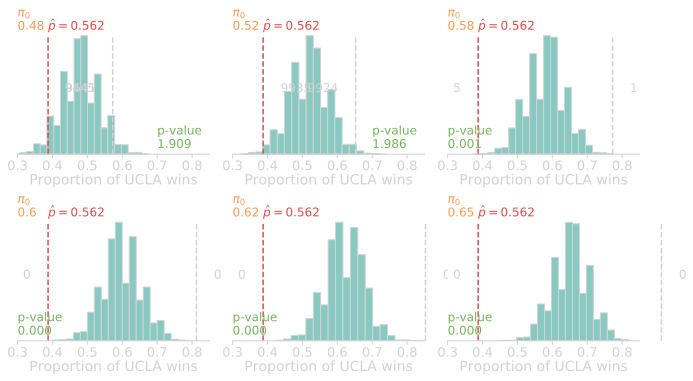

In [78]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = pyp.subplots(ncols=3, nrows=2, figsize=(9, 6))

for it,(ax,null) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6],[0.48, 0.52, 0.58, 0.6, 0.62, 0.65])):
    n_simul = B
    n_games=TOTAL
    res = np.zeros(n_simul)
    for i in range(n_simul):
        sample = np.random.rand(n_games)
        res[i] = np.sum(sample<null)/n_games
    ax.hist(res, bins=20, edgecolor=col["grey"], color=col["blue"])
    ax.set_xlim(0.35, 0.85)
    ax.axvline(pLA, ymax=0.95, color=col["red"], ls="--")
    ax.text(pLA, ax.get_ylim()[1], "$\hat{p}=0.562$", size=12, color=col["red"], ha="left")
    ax.text(ax.get_xlim()[0]-0.05, ax.get_ylim()[1], "$\pi_0$\n{}".format(null), size=12, color=col["orange"], ha="left")
    if it<2:
        n1 = np.sum(res>=pLA)
        n2 = np.sum(res<=(null-(pLA-null)))
        ax.text(pLA+0.05, ax.get_ylim()[1]*0.5, "{}".format(n1), size=12, color=col["grey"], ha="left")
        ax.text(null-(pLA-null)-0.05, ax.get_ylim()[1]*0.5, "{}".format(n2), size=12, color=col["grey"], ha="right")
        ax.axvline(null-(pLA-null), ymin=0, ymax=0.95, color=col["grey"], ls="--", clip_on=False)
        ax.text(ax.get_xlim()[1]-0.15, ax.get_ylim()[1]*0.05, "p-value\n{:.3f}".format((n1+n2)/n_simul), size=12, color=col["green"], ha="left")
    else:
        n1 = np.sum(res<=pLA)
        n2 = np.sum(res>=(null-(pLA-null)))
        ax.text(pLA-0.05, ax.get_ylim()[1]*0.5, "{}".format(n1), size=12, color=col["grey"], ha="right")
        ax.text(null-(pLA-null)+0.05, ax.get_ylim()[1]*0.5, "{}".format(n2), size=12, color=col["grey"], ha="left")
        ax.axvline(null-(pLA-null), ymin=0, ymax=0.95, color=col["grey"], ls="--", clip_on=False)
        ax.text(ax.get_xlim()[0]-0.05, ax.get_ylim()[1]*0.05, "p-value\n{:.3f}".format((n1+n2)/n_simul), size=12, color=col["green"], ha="left")

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    for spine in ["bottom"]:
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color(col["grey"])
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.tick_params(axis="x", width=1, size=4, color=col["grey"], labelcolor=col["grey"], 
                   labelsize=13, pad=2)
    ax.set_xlabel("Proportion of UCLA wins", size=14, color=col["grey"], labelpad=1)
    ax.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    
#pyp.tight_layout()
pyp.subplots_adjust(left=0.02, bottom=0.17, right=0.98, top=0.89,
                wspace=0.12, hspace=0.5)

#pyp.savefig("/Users/Gui/Box Sync/_STATS13/_Slides/_stats13-Lectures/assets/img/lec/ucla-usc-simulation-increasing-null.svg", transparent=True)